# Prepare inputs for a simulation data

## Introduction

In this tutorial, we will go through the steps of building spatial RNA graphs for "unsupervised" spatial neighbourbood learning using graph neural network models. Here we focus on spatial transcriptomics data from imaging-based platforms which produce the list of detected transcripts with physical coordinates in the tissue space. 

For the purpose of demonstration, we will analyze a synthetic dataset that has been generated using the simulation module from [ficture](https://github.com/seqscope/ficture/). Briefly, transcripts from ten distinct cell types were simulated and arranged in three shapes in the 2D space. Two cells types have been placed randomly (scattered) across the space and the rest cells have been more restriced to a particular area.

## The simulated data with ground truth cell type labels

Simulation data was generated using the script below, which was adapted from [ficture](https://github.com/seqscope/ficture/blob/main/examples/simulation.md).
A copy of the simulation data can be found on [Zenoto](https://zenodo.org/records/15550214)

<details>
  <summary>bash script - simulation</summary>
  
  ```bash
      #!/bin/bash
    
    path=gen_sim/simulated/data # where to store the simulated dataset
    gitpath=../ficture # location of ficture
    xmax=500 # dimension of the simulated data in um
    ymax=500
    avg_umi_per_pixel=1 # each pixel is exactly one molecule, mimicking data from imaging-based technologies
    pixel_density=4 # average number of pixels per 1 um^2
    background=0.2 # extracellular region has lower density
    cdist=15 # average distance between cell centers
    f_scatter=0.2 # fraction of cells that are "scattered"    
    model=${gitpath}/examples/simulation/model.tsv.gz
    spike="Kupffer_cell granulocyte" # cell types that are scattered across the region
    block="fibroblast epithelial_cell_of_proximal_tubule endothelial_cell keratinocyte hepatocyte cardiac_muscle_cell immature_NK_T_cell cell_of_skeletal_muscle" # cell types that are localized
    
    
    python ${gitpath}/examples/simulation/simu.py --path ${path} \
        --model ${model} --spike ${spike} --block ${block} --block_x ${xmax} \
        --block_y ${ymax} --avg_umi_per_pixel ${avg_umi_per_pixel} \
        --pixel_density ${pixel_density} --f_rod 0.3 --f_diamond 0.3 \
        --background ${background} \
        --f_scatter ${f_scatter} --avg_cdist ${cdist} --seed 1984
        
    ## prep ficture input 
    ./examples/simulation/cmd_prepare.sh path=${path} width=12 sliding_step=2
    
    ## run ficture
    ./examples/simulation/cmd_ficture.sh path=${path} nFactor=10 thread=1 train_width=12 train_nEpoch=5
    
    ## run eval
    
    output_path=${path}/analysis/nF10.d_12
    prefix=nF10.d_12.decode.prj_9.r_3_4
    # query=${output_path}/${prefix}.pixel.sorted.tsv.gz
    # output=${output_path}/${prefix}
    # nFactor=10
    # python ${gitpath}/examples/simulation/simu.eval.py --path ${path} --query ${query} --output ${output} --K1 ${nFactor} --query_scale 0.01
    
    ## plot error 
    
    input=${output_path}/${prefix}.bad_pixel.tsv.gz
    cmap=${path}/model.rgb.tsv
    figure_path=${output_path}/figure/
    output=${figure_path}/${prefix}.bad_pixel
    ficture plot_base --input ${input} --output ${output} --color_table ${cmap} --xmin 0 --xmax $xmax --ymin 0 --ymax $ymax \
                      --plot_um_per_pixel 0.5 --category_column cell_label --color_table_category_name cell_label
    
    ## plot using match to true label
    
    input=${output_path}/${prefix}.pixel.sorted.tsv.gz
    cmap=${output_path}/${prefix}.matched.rgb.tsv
    output=${figure_path}/${prefix}.repaint.pixel.png
    pixel_resolution=0.5
    ficture plot_pixel_full --input ${input} --color_table ${cmap} --output ${output} --plot_um_per_pixel ${pixel_resolution} --full
  ```
</details>

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torch_geometric.nn import radius_graph
from torch_geometric import seed_everything
import torch
import os.path as osp
import time
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader,NeighborLoader
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import random 
from pathlib import Path


In [ ]:
## for reproduciable results
seed = 1024
random.seed(seed)  # python random seed
np.random.seed(seed)  # numpy random seed
torch.manual_seed(seed)  # pytorch random seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_everything(seed)


## Visualise the simulated transcripts and cell types


Specify dataset dir as required.

In [ ]:

# Define the dataset directory using pathlib
dataset_dir = Path("..") / "data"
ground_truth_label =  pd.read_csv(dataset_dir / "pixel_label.uniq.tsv.gz",sep="\t")
ground_truth_rgb = pd.read_csv(dataset_dir / "model.rgb.tsv", sep="\t")


In [ ]:
ground_truth_rgb


,Name,cell_label,R,G,B
0,0,Kupffer_cell,0.94118,0.78824,0.81176
1,1,granulocyte,0.50588,0.23529,0.52157
2,2,fibroblast,0.99608,0.63137,0.18431
3,3,epithelial_cell_of_proximal_tubule,0.27451,0.40000,0.86667
4,4,endothelial_cell,0.54510,0.99608,0.29412
5,5,keratinocyte,0.90980,0.29412,0.04706
6,6,hepatocyte,0.01569,0.45882,0.10980
7,7,cardiac_muscle_cell,0.85490,0.88627,0.21176
8,8,immature_NK_T_cell,0.66275,0.08235,0.00392
9,9,cell_of_skeletal_muscle,0.18431,0.69412,0.95294


A total of 10 cell types were simulated.

In [ ]:
set(ground_truth_label.cell_label)


{'Kupffer_cell',
 'cardiac_muscle_cell',
 'cell_of_skeletal_muscle',
 'endothelial_cell',
 'epithelial_cell_of_proximal_tubule',
 'fibroblast',
 'granulocyte',
 'hepatocyte',
 'immature_NK_T_cell',
 'keratinocyte'}

Specify color maps for ten cell types.

In [ ]:
## specify color maps
c_array = np.array(ground_truth_rgb[["R","G","B"]])
color_m = dict(zip(ground_truth_rgb.cell_label,range(0,10)))
color_m


{'Kupffer_cell': 0,
 'granulocyte': 1,
 'fibroblast': 2,
 'epithelial_cell_of_proximal_tubule': 3,
 'endothelial_cell': 4,
 'keratinocyte': 5,
 'hepatocyte': 6,
 'cardiac_muscle_cell': 7,
 'immature_NK_T_cell': 8,
 'cell_of_skeletal_muscle': 9}

### Display the simulated transcripts with groundtruth cell type label

In the plot below, each data point represents one RNA transcript and has been colored by the cell type it comes from. 

We simulated transcripts for a 500 by 500 square tissue for 10 cell types with different shapes and sizes. 

```{figure} ../figures/simulation_setting.jpg
---
height: 250px
name: cellshapes-fig
align: left
---
Sizes of simulated cell shapes.

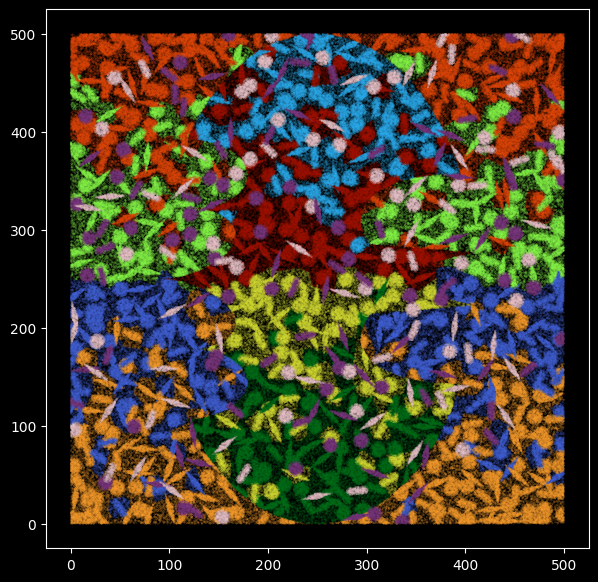

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(7,7))
plt.rcParams['figure.facecolor'] = 'black'
plt.scatter(y = ground_truth_label.X,x = ground_truth_label.Y,s=0.01,
            c=[c_array[color_m[x]] for x in ground_truth_label.cell_label],alpha=0.8)


## Apply GNN to learn spatial neighbourhoods of molecules in the tissue

### Building RNA-transcript spatial graphs 

We next construct a spatial graph for all the mRNA transcripts in the simulated dataset. In this graph, each node represents a transcript, we connect nodes when their physical distance is smaller than a `radius_r`, i.e., edges are added between transcripts that sit close (< `radius_r`)in the physical space. We initialize each node's input feature with the transcript's gene labels after one-hot-encoding transformation. The graph is stored as `torch_geometric.data.Data`. 



#### Format directory to use SpatialRNA on the simulated data

We will use the `SpatialRNA` function for constructing the graph data from the input transcripts. `SpatialRNA` expects input files in a certain directory structure, for example, for `sample_x`, 
```console
./data_dir/sample_x/raw/sample_x.csv
```
,where `sample_x.csv` is the CSV file with list of detected transcripts (aftering removing non-gene transcripts, i.e., control probes).

In [ ]:

!mkdir -p '../data/sim_sample/raw/'
!zcat ../data/matrix.tsv.gz | tr '\t' ',' > ../data/sim_sample/raw/sim_sample.csv


## Filtering of low-quality and control scripts

An important step of preparing the input transcripts is filtering of low-quality and control scripts. For this simple simulation data, there is no NegControl probes in the list of detected transcripts, however in real data analysis filtering of negative control step is required. 


Now we can move to the application of spatialRNA in next [step](./02_Quick_start_simulation_data.ipynb)

